In [132]:
import ddsp
import soundfile as sf
import numpy as np


import tensorflow.compat.v2 as tf
import ddsp.training
import librosa
import pickle

import matplotlib.pyplot as plt

import IPython.display as ipd
import time
import gin
sample_rate = 16000
from ddsp.training.postprocessing import (
    detect_notes, fit_quantile_transform
)

from ddsp.colab.colab_utils import (
    auto_tune, get_tuning_factor)

In [142]:
from pydub import AudioSegment

track = AudioSegment.from_file("./data/test_trumpet.m4a", format="m4a")
file_handle = track.export("test_trumpet.wav", format="wav")

In [143]:
# test_audio, samp_rate = sf.read("./data/test_trumpy.wav")
# print("SAMP:", samp_rate)

# test_audio = test_audio[np.newaxis, :]


test_resamp, rate = librosa.load("./data/test_trumpet.wav", sr=sample_rate)
test_resamp = test_resamp[np.newaxis, :]


ipd.Audio(test_resamp, rate=rate)

In [144]:
ddsp.spectral_ops.reset_crepe()

start = time.time()

audio_features = ddsp.training.metrics.compute_audio_features(test_resamp)

/Users/doriclink/Library/Python/3.9/lib/python/site-packages/librosa/core/convert.py:1332: RuntimeWarning: divide by zero encountered in log10
  + 2 * np.log10(f_sq)


In [145]:
# for each in audiofeatures.keys():
    # print(each, features[each].shape)

audio_features["loudness_db"] = audio_features["loudness_db"].numpy().astype(np.float32)

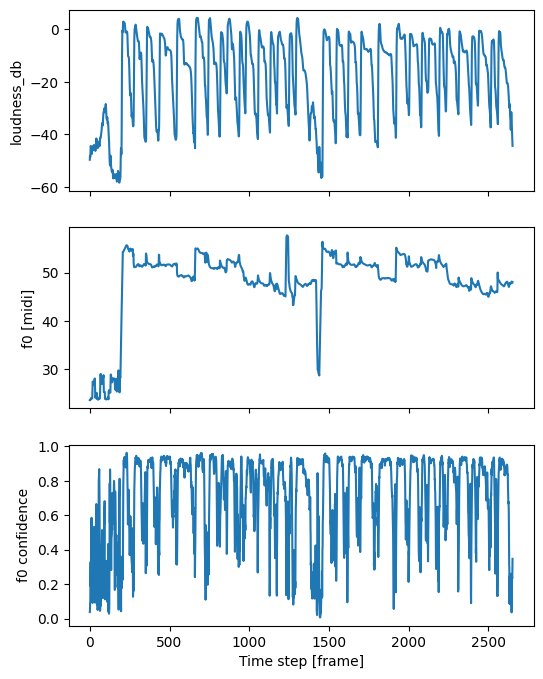

In [146]:
TRIM = -15
fig, ax = plt.subplots(nrows=3, 
                       ncols=1, 
                       sharex=True,
                       figsize=(6, 8))
ax[0].plot(audio_features['loudness_db'][:TRIM])
ax[0].set_ylabel('loudness_db')

ax[1].plot(librosa.hz_to_midi(audio_features['f0_hz'][:TRIM]))
ax[1].set_ylabel('f0 [midi]')

ax[2].plot(audio_features['f0_confidence'][:TRIM])
ax[2].set_ylabel('f0 confidence')
_ = ax[2].set_xlabel('Time step [frame]')

In [147]:
import os
model_dir = "checkpoints/trumpet_pretrained/"
gin_file = os.path.join(model_dir, "operative_config-0.gin")
print(gin_file)


STATS = None
stats_file = "checkpoints/trumpet_pretrained/dataset_statistics.pkl"
try:
    with open(stats_file, "rb") as f:
        STATS = pickle.load(f)
except Exception as err:
    print(err)



with gin.unlock_config():
    gin.parse_config_file(gin_file, skip_unknown=True)

ckpt = "./checkpoints/trumpet_pretrained/ckpt-20000.index"

time_steps_train = gin.query_parameter('F0LoudnessPreprocessor.time_steps')
n_samples_train = gin.query_parameter('Harmonic.n_samples')
hop_size = int(n_samples_train / time_steps_train)

time_steps = int(test_resamp.shape[1] / hop_size)
n_samples = time_steps * hop_size


gin_params = [
    'Harmonic.n_samples = {}'.format(n_samples),
    'FilteredNoise.n_samples = {}'.format(n_samples),
    'F0LoudnessPreprocessor.time_steps = {}'.format(time_steps),
    'oscillator_bank.use_angular_cumsum = True',  # Avoids cumsum accumulation errors.
]

with gin.unlock_config():
  gin.parse_config(gin_params)


# Trim all input vectors to correct lengths 
for key in ['f0_hz', 'f0_confidence', 'loudness_db']:
  audio_features[key] = audio_features[key][:time_steps]
audio_features['audio'] = audio_features['audio'][:, :n_samples]



model = ddsp.training.models.Autoencoder()
model.restore("./checkpoints/trumpet_pretrained/")

checkpoints/trumpet_pretrained/operative_config-0.gin


In [148]:

for each in audio_features.items():
    print(each[0], type(each[1]))

audio <class 'numpy.ndarray'>
loudness_db <class 'numpy.ndarray'>
f0_hz <class 'numpy.ndarray'>
f0_confidence <class 'numpy.ndarray'>


In [151]:
threshold =  #@param {type:"slider", min: 0.0, max:2.0, step:0.01}
ADJUST = True #@param{type:"boolean"}
quiet = 20 #@param {type:"slider", min: 0, max:60, step:1}
autotune = 0.0 #@param {type:"slider", min: 0.0, max:1.0, step:0.1}
pitch_shift =  0 #@param {type:"slider", min:-2, max:2, step:1}
loudness_shift = 2 #@param {type:"slider", min:-20, max:20, step:1}
audio_features_mod = {k: v.copy() for k, v in audio_features.items()}


def shift_ld(audio_features, ld_shift=0.0):
  """Shift loudness by a number of ocatves."""
  audio_features['loudness_db'] += ld_shift
  return audio_features


def shift_f0(audio_features, pitch_shift=0.0):
  """Shift f0 by a number of ocatves."""
  audio_features['f0_hz'] *= 2.0 ** (pitch_shift)
  audio_features['f0_hz'] = np.clip(audio_features['f0_hz'], 
                                    0.0, 
                                    librosa.midi_to_hz(110.0))
  return audio_features


mask_on = None

if ADJUST and STATS is not None:
  # Detect sections that are "on".
  mask_on, note_on_value = detect_notes(audio_features['loudness_db'],
                                        audio_features['f0_confidence'],
                                        threshold)

  if np.any(mask_on):
    # Shift the pitch register.
    target_mean_pitch = STATS['mean_pitch']
    pitch = ddsp.core.hz_to_midi(audio_features['f0_hz'])
    mean_pitch = np.mean(pitch[mask_on])
    p_diff = target_mean_pitch - mean_pitch
    p_diff_octave = p_diff / 12.0
    round_fn = np.floor if p_diff_octave > 1.5 else np.ceil
    p_diff_octave = round_fn(p_diff_octave)
    audio_features_mod = shift_f0(audio_features_mod, p_diff_octave)


    # Quantile shift the note_on parts.
    _, loudness_norm = fit_quantile_transform(
        audio_features['loudness_db'],
        mask_on,
        inv_quantile=STATS['quantile_transform'])

    # Turn down the note_off parts.
    mask_off = np.logical_not(mask_on)
    loudness_norm[mask_off] -=  quiet * (1.0 - note_on_value[mask_off][:, np.newaxis])
    loudness_norm = np.reshape(loudness_norm, audio_features['loudness_db'].shape)
    
    audio_features_mod['loudness_db'] = loudness_norm 

    # Auto-tune.
    if autotune:
      f0_midi = np.array(ddsp.core.hz_to_midi(audio_features_mod['f0_hz']))
      tuning_factor = get_tuning_factor(f0_midi, audio_features_mod['f0_confidence'], mask_on)
      f0_midi_at = auto_tune(f0_midi, tuning_factor, mask_on, amount=autotune)
      audio_features_mod['f0_hz'] = ddsp.core.midi_to_hz(f0_midi_at)

  else:
    print('\nSkipping auto-adjust (no notes detected or ADJUST box empty).')

else:
  print('\nSkipping auto-adujst (box not checked or no dataset statistics found).')

# Manual Shifts.
audio_features_mod = shift_ld(audio_features_mod, loudness_shift)
audio_features_mod = shift_f0(audio_features_mod, pitch_shift)



# Plot Features.
has_mask = int(mask_on is not None)
n_plots = 3 if has_mask else 2 
fig, axes = plt.subplots(nrows=n_plots, 
                      ncols=1, 
                      sharex=True,
                      figsize=(2*n_plots, 8))

if has_mask:
  ax = axes[0]
  ax.plot(np.ones_like(mask_on[:TRIM]) * threshold, 'k:')
  ax.plot(note_on_value[:TRIM])
  ax.plot(mask_on[:TRIM])
  ax.set_ylabel('Note-on Mask')
  ax.set_xlabel('Time step [frame]')
  ax.legend(['Threshold', 'Likelihood','Mask'])

ax = axes[0 + has_mask]
ax.plot(audio_features['loudness_db'][:TRIM])
ax.plot(audio_features_mod['loudness_db'][:TRIM])
ax.set_ylabel('loudness_db')
ax.legend(['Original','Adjusted'])

ax = axes[1 + has_mask]
ax.plot(librosa.hz_to_midi(audio_features['f0_hz'][:TRIM]))
ax.plot(librosa.hz_to_midi(audio_features_mod['f0_hz'][:TRIM]))
ax.set_ylabel('f0 [midi]')
 = ax.legend(['Original','Adjusted'])

IndentationError: unexpected indent (504957556.py, line 104)

In [152]:
out = model(audio_features_mod, training=False)
audio_gen = model.get_audio_from_outputs(out)

ipd.Audio(audio_gen, rate=sample_rate)

/Users/doriclink/Library/Python/3.9/lib/python/site-packages/librosa/core/convert.py:1332: RuntimeWarning: divide by zero encountered in log10
  + 2 * np.log10(f_sq)
